Nearest Neighbor is a technique that helps identify similar entities based on their properties.
For example in the one picture below, it illistrates how one might use this technique to recommend movies to a person that are similar to a movie they like. This uses properties like the year, genre, and rating.

![image.png](screenshots/nn_intro.png)

A more efficeint way to find similar movies instead of going one-by-one over thousands of movies would be to use approximate neartest neighbor. To use approximate nearest neighbor there is a tool called ANNOY

After first installing Microsoft Visual C++ Build Tools, I could then install ANNOY and import it

In [3]:
from annoy import AnnoyIndex

In [4]:
import numpy as np
import matplotlib.pylab as plt

Lets now look at some data

In [5]:
columns = 2

vecs = np.concatenate([
    np.random.normal(-1, 1, (5000, columns)),
    np.random.normal(0, 0.5, (5000, columns))
])

As we can see below, the above code plots two dimentional data of 10,000 points

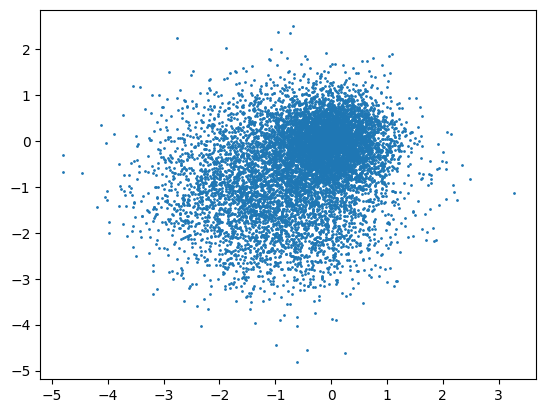

In [6]:
plt.scatter(vecs[:, 0], vecs[:, 1], s=1)

Lets first create an ANNOY index

In [7]:
annoy = AnnoyIndex(columns, 'euclidean')
for i in range(vecs.shape[0]):
    annoy.add_item(i, vecs[i, :])
annoy.build(n_trees=1)

True

The following code can now give us the 20 nearest neighbors indices based on the point (0.0, 0.0)

In [8]:
annoy.get_nns_by_vector(np.array([0.0, 0.0]), 20)

[9811,
 5248,
 6847,
 5158,
 6066,
 9525,
 5056,
 9691,
 4225,
 7737,
 6051,
 5251,
 8477,
 7688,
 8419,
 9387,
 7138,
 5698,
 7224,
 9863]

Now lets actually plot them

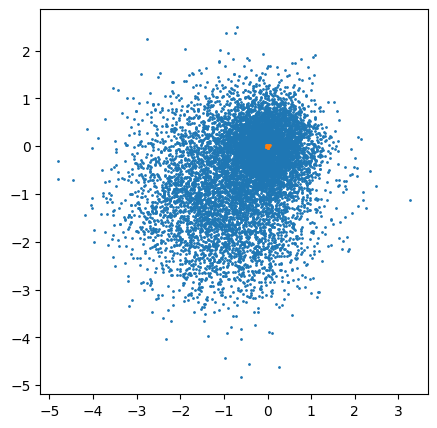

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(vecs[:, 0], vecs[:, 1], s=1)

indices = annoy.get_nns_by_vector(np.array([-0., -0.]), 20)

subset = vecs[indices, :]
plt.scatter(subset[:, 0], subset[:, 1], s=1)

We can see the orange section of the plot that represent the 20 nearest neighbors around the point (0, 0).

Now lets look at the closest 2000 points

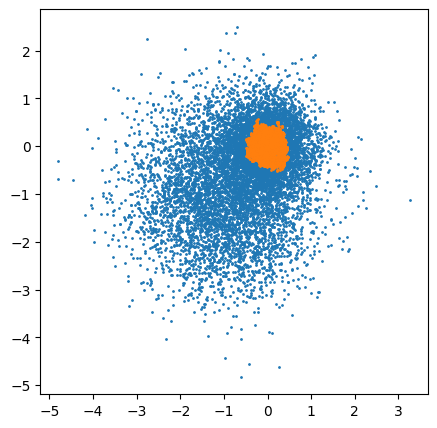

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(vecs[:, 0], vecs[:, 1], s=1)

indices = annoy.get_nns_by_vector(np.array([-0., -0.]), 2000)

subset = vecs[indices, :]
plt.scatter(subset[:, 0], subset[:, 1], s=1)

One might think that the closest points around the point (0, 0) would basically create a perfect circle. But we can see that the orange area is not a perfect circle meaning we can see blue points that are closer our point than some orange ones.

Remember that ANNOY is approximate nearest neighbor and not exact nearest neighbors.

Lets now look at it again from a different point (-1, -1) making it clearer that its not perfect

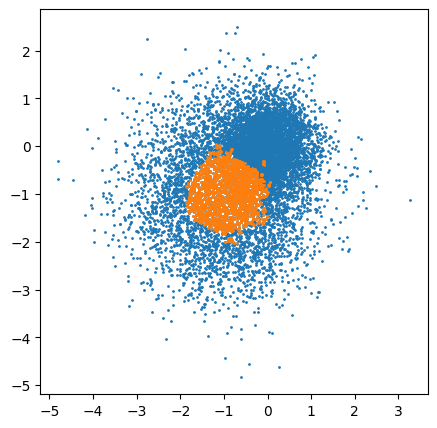

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(vecs[:, 0], vecs[:, 1], s=1)

indices = annoy.get_nns_by_vector(np.array([-1., -1.]), 2000)

subset = vecs[indices, :]
plt.scatter(subset[:, 0], subset[:, 1], s=1)

The way Annoy works is that it takes the two dimentional plot of the data and starts picking two random points that it then draws a line between. Those two points are now on opposite sides of that line and are then labeled either left or right. It then continues to do this with two random points on the same side of a line and drawing a new line without intersecting any previous lines. This then makes a decision tree like tructure where every point in the plot can then be classified in an area based on the sides of the lines that it is on.

This now creates relatively small subsets of points. When a new data point is introduced, we can now only concern ourselves with the subset it is in. This greatly simplifies finding the nearest neighbor for the system but it is not perfect since it can start looking at points that are further away than points technically closer to it in a different subset. This is why it is approximate.

![image.png](screenshots/annoy_tree.png)

To be more accurate we can actually use multiple trees and overlap them so that the subsets become smaller and thus more accurate. But the cost is it does take more computational time.

![image.png](screenshots/annoy_tree2.png)

lets now take the most recent plot and change the number of trees to 10. We can see that it is now much more of a circle, thus it is now more accurate

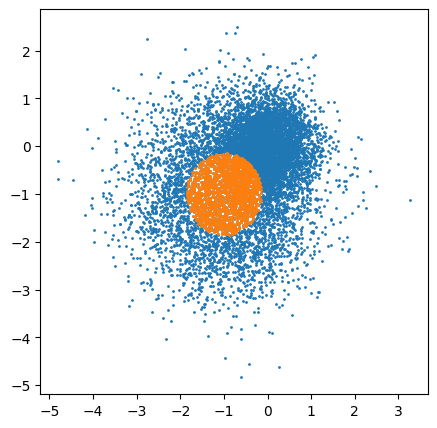

In [14]:
annoy = AnnoyIndex(columns, 'euclidean')
for i in range(vecs.shape[0]):
    annoy.add_item(i, vecs[i, :])
annoy.build(n_trees=10)

plt.figure(figsize=(5,5))
plt.scatter(vecs[:, 0], vecs[:, 1], s=1)

indices = annoy.get_nns_by_vector(np.array([-1., -1.]), 2000)

subset = vecs[indices, :]
plt.scatter(subset[:, 0], subset[:, 1], s=1)

Lets now benchmark annoy to see how fast it is.

In [15]:
from sklearn.neighbors import NearestNeighbors
query = np.array([-2., -2.])
q = np.array([query])
n = 10

In [16]:
nn = NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(vecs)

In [17]:
%%timeit
distances, indices = nn.kneighbors(q)

168 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
nn = NearestNeighbors(n_neighbors=n, algorithm='kd_tree').fit(vecs)

In [19]:
%%timeit
distances, indices = nn.kneighbors(q)

166 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
nn = NearestNeighbors(n_neighbors=n, algorithm='brute').fit(vecs)

In [21]:
%%timeit
distances, indices = nn.kneighbors(q)

334 µs ± 5.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can see that 'ball_tree' and 'kd_tree' are very close to each other and very fast with times of 168 µs and 166 µs respectively. The brute force method took much longer with 334 µs.

Now lets look at how Annoy performs

In [22]:
annoy = AnnoyIndex(columns, 'euclidean')
for i in range(vecs.shape[0]):
    annoy.add_item(i, vecs[i, :])
annoy.build(n_trees=10)

True

In [23]:
%%timeit
annoy.get_nns_by_vector(query, n)

6.1 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We can see that annoy is MUCH faster with only needing 6.1 µs to compute